In [333]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2)) 
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def create_X(x, y, n):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)

	N = len(x)
	l = int((n+1)*(n+2)/2)		# Number of elements in beta
	X = np.ones((N,l))

	for i in range(1,n+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k)

	return X

RANDOM_STATE = 42069

polygrad = 10
N = 50  # Number of points
noise = 0.05

x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
x, y = np.meshgrid(x, y)

np.random.seed(RANDOM_STATE)

conf_intervals = np.zeros((n, 2))

z = FrankeFunction(x, y)
z += noise * np.random.randn(z.shape[0], z.shape[1])

X = create_X(x, y, polygrad)

X_train, X_test, z_train, z_test = train_test_split(X, z.reshape(-1, 1), test_size=0.3, random_state=RANDOM_STATE)

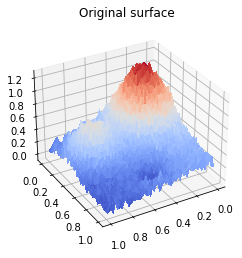

In [309]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
ax.set_title('Original surface')
ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.view_init(30, 60)

plt.savefig('../figures/franke_original', dpi=300, bbox_inches='tight', transparent=True)

In [350]:
# When the lmb parameter is 0, the gradient will be the same as linear regression.
def SGD(X, y, n_epochs, batch_size, eta, lmb=0, eta_scaling='constant'):
    datapoints = X.shape[0]
    beta = np.random.randn(X.shape[1], 1)
    eta0 = eta
    for epoch in range(n_epochs):
        perm = np.random.permutation(datapoints)
        X_shuffled = X[perm, :]
        y_shuffled = y[perm, :]
        for i in range(0, datapoints, batch_size):
            x_i = X_shuffled[i:i+batch_size, :]
            y_i = y_shuffled[i:i+batch_size, :]
            if eta_scaling == 'optimal':
                t = epoch * (datapoints // batch_size) + i // batch_size
                eta = 1 / (t + 10)
            gradient = (2 / batch_size) * (x_i.T @ ((x_i @ beta) - y_i) + lmb * beta)
            beta = beta - gradient * eta
    return beta

In [294]:
n_rates = 20

rates = np.logspace(-3, -.55, n_rates)
test_mse = np.zeros(n_rates)
test_r2 = np.zeros(n_rates)

j = 0
for i in rates:
    betas = SGD(X_train, z_train, 100, 200, i)
    pred = X_test @ betas
    test_mse[j] = mean_squared_error(z_test, pred)
    test_r2[j] = r2_score(z_test, pred)
    j += 1

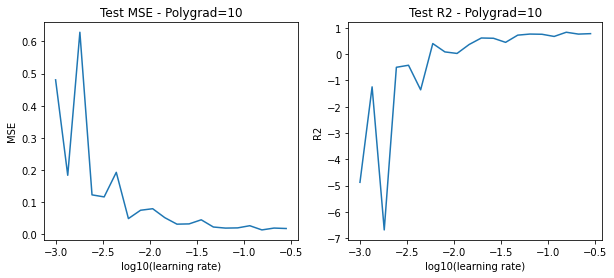

In [313]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(np.log10(rates), test_mse)
ax1.set_title('Test MSE - Polygrad={}'.format(polygrad))
ax1.set_xlabel('log10(learning rate)')
ax1.set_ylabel('MSE')
ax2.plot(np.log10(rates), test_r2)
ax2.set_title('Test R2 - Polygrad={}'.format(polygrad))
ax2.set_xlabel('log10(learning rate)')
ax2.set_ylabel('R2')
fig.set_figwidth(10)

plt.savefig('../figures/sgd_linreg_constant_eval', dpi=300, bbox_inches='tight', transparent=True)

Test R2:   0.913677131960744
Test MSE:  0.007054333840065143


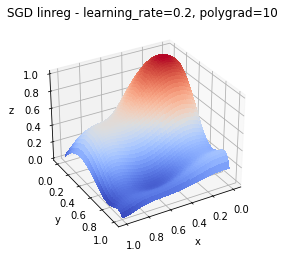

In [318]:
learning_rate = 0.2
mini_batch_size = 15
n_epochs = 1000

beta_SGD_linreg = SGD(X_train, z_train, n_epochs, mini_batch_size, learning_rate)
z_pred = X_test @ beta_SGD_linreg
z_SGD = (X @ beta_SGD_linreg).reshape(z.shape)

print("Test R2:   {}".format(r2_score(z_test, z_pred)))
print("Test MSE:  {}".format(mean_squared_error(z_test, z_pred)))

fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
ax.plot_surface(x, y, z_SGD, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.view_init(30, 60)
ax.set_title('SGD linreg - learning_rate={}, polygrad={}'.format(learning_rate, polygrad))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.savefig('../figures/sgd_linreg_constant_surface', dpi=300, bbox_inches='tight', transparent=True)

Test R2:   0.9656028122872524
Test MSE:  0.002810949761015374


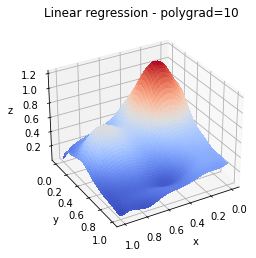

In [316]:
beta_linreg = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ z_train
z_pred = X_test @ beta_linreg
z_linreg = (X @ beta_linreg).reshape(z.shape)

print("Test R2:   {}".format(r2_score(z_test, z_pred)))
print("Test MSE:  {}".format(mean_squared_error(z_test, z_pred)))

fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
ax.plot_surface(x, y, z_linreg, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.view_init(30, 60)
ax.set_title('Linear regression - polygrad={}'.format(polygrad))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.savefig('../figures/franke_linreg_sufrace', dpi=300, bbox_inches='tight', transparent=True)

Optimal lambda:  0.0001
Test R2:   0.9483013840178606
Test MSE:  0.0042248283043780305


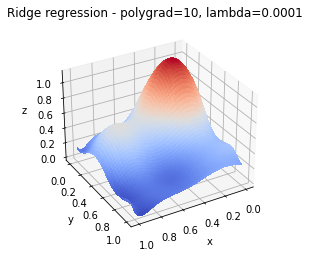

In [392]:
optimal_lambda = 0
best_R2 = 0
lambdas = np.logspace(-4, 1, 20)
I = np.eye(X_train.shape[1])

for lmb in lambdas:
    beta_ridge = np.linalg.inv(X_train.T @ X_train + lmb * I) @ X_train.T @ z_train
    z_pred = X_test @ beta_ridge

    r2 = r2_score(z_test, z_pred)

    if best_R2 < r2:
        optimal_lambda = lmb
        best_R2 = r2

print('Optimal lambda: ', optimal_lambda)

beta_ridge = np.linalg.inv(X_train.T @ X_train + optimal_lambda * I) @ X_train.T @ z_train
z_pred = X_test @ beta_ridge
z_ridge = (X @ beta_ridge).reshape(z.shape)

print("Test R2:   {}".format(r2_score(z_test, z_pred)))
print("Test MSE:  {}".format(mean_squared_error(z_test, z_pred)))

fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
ax.plot_surface(x, y, z_ridge, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.view_init(30, 60)
ax.set_title('Ridge regression - polygrad={}, lambda={}'.format(polygrad, optimal_lambda))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.savefig('../figures/franke_ridge_sufrace', dpi=300, bbox_inches='tight', transparent=True)

In [411]:
from tqdm import tqdm

n = 20
mini_batch_size = 15
n_epochs = 1000

lambdas = np.logspace(-4, 1, n)
rates = np.logspace(-3, -1, n)
I = np.eye(X_train.shape[1])

r2_scores = np.zeros((n, n))

for lmb in tqdm(range(n)):
    for rate in range(n):
        beta_SGD_ridge = SGD(X_train, z_train, n_epochs, mini_batch_size, rates[rate], lmb=lambdas[lmb])
        z_pred = X_test @ beta_SGD_ridge

        r2_scores[lmb, rate] = r2_score(z_test, z_pred)

100%|██████████| 20/20 [05:21<00:00, 16.08s/it]


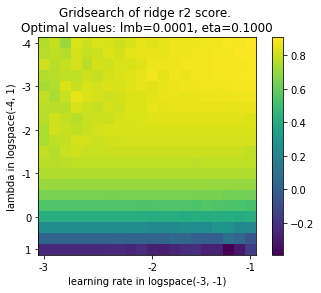

In [412]:
idx = np.where(r2_scores == np.amax(r2_scores))
lmb_optimal = lambdas[idx[0]][0]
eta_optimal = rates[idx[1]][0]

fig, ax = plt.subplots()
cb = ax.imshow(r2_scores)
ax.set_ylabel('lambda in logspace(-4, 1)')
ax.set_xlabel('learning rate in logspace(-3, -1)')
ax.set_title('Gridsearch of ridge r2 score. \nOptimal values: lmb={:.4f}, eta={:.4f}'.format(lmb_optimal, eta_optimal))
plt.colorbar(cb)
plt.xticks([0, 10, 19], [-3, -2, -1])
plt.yticks([0, 4, 8, 12, 16, 19], [-4, -3, -2, -1, 0, 1])

plt.savefig('../figures/gridsearch_eta_lmb_ridge', dpi=300, bbox_inches='tight', transparent=True)

Test R2:   0.9126947122486371
Test MSE:  0.007134617509707716


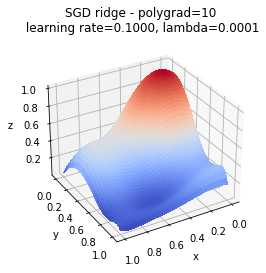

In [419]:
mini_batch_size = 15

beta_SGD_linreg = SGD(X_train, z_train, n_epochs, mini_batch_size, 0.2, lmb=lmb_optimal)
z_pred = X_test @ beta_SGD_linreg
z_SGD = (X @ beta_SGD_linreg).reshape(z.shape)

print("Test R2:   {}".format(r2_score(z_test, z_pred)))
print("Test MSE:  {}".format(mean_squared_error(z_test, z_pred)))

fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
ax.plot_surface(x, y, z_SGD, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.view_init(30, 60)
ax.set_title('SGD ridge - polygrad={}\n learning rate={:.4f}, lambda={:.4f}'.format(polygrad, eta_optimal, lmb_optimal))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.savefig('../figures/sgd_ridge_optimal', dpi=300, bbox_inches='tight', transparent=True)